# MUNG to MIDI


The ``mung`` (**Mu**sic **N**otation **G**raph) package implements a graph representation
 of music notation that is especially amenable to Optical Music Recognition (OMR).
It was used for instance in the [MUSCIMA++](https://ufal.mff.cuni.cz/muscima) dataset of music notation.

[![Build Status](https://travis-ci.org/OMR-Research/mung.svg?branch=master)](https://travis-ci.org/OMR-Research/mung)
[![PyPI version](https://badge.fury.io/py/mung.svg)](https://badge.fury.io/py/mung)
[![Documentation Status](https://readthedocs.org/projects/mung/badge/?version=latest)](https://mung.readthedocs.io/en/latest/?badge=latest)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-MIT-brightgreen.svg)](LICENSE.txt)
[![codecov](https://codecov.io/gh/OMR-Research/mung/branch/master/graph/badge.svg)](https://codecov.io/gh/OMR-Research/mung)

Requires Python >= 3.6.

## Getting started

1. Install this package: ``pip install mung``
2. Download the [MUSCIMA++ dataset](https://github.com/OMR-Research/muscima-pp).
3. Run through the [tutorial](https://muscima.readthedocs.io/en/latest/Tutorial.html#tutorial).

Fundamentally, the Music Notatation Graph is a very simple construct:

![](doc/MuNG%20Class%20Diagram.png)

It stores the primitives that can be detected by a [Music Object Detector](https://github.com/apacha/MusicObjectDetector-TF)
as nodes and then store the relations between those nodes. But the devil is
in the details. To better understand what kind of [relations are useful](https://archives.ismir.net/ismir2019/paper/000006.pdf) 
and which kind of relations are stored for common western music notation, check out the
[annotator instruction from MUSCIMarker](https://muscimarker.readthedocs.io/en/latest/instructions.html).


## Dataset
The dataset itself is available for download
[here](https://github.com/OMR-Research/muscima-pp) and due to its derived nature, licensed differently:

[![abc](https://img.shields.io/badge/Dataset_Version-2.0-brightgreen.svg)](https://github.com/OMR-Research/muscima-pp)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-blue.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)


### Introduction to MUSCIMA++ Video

Watch Jan give a 30 minute introduction into this dataset on YouTube, which explains many design decisions and thoughts that directly affected the creation of the MuNG format:

[![Introduction to MUSCIMA++](https://img.youtube.com/vi/SvBvcxdGoE8/0.jpg)](https://www.youtube.com/watch?v=SvBvcxdGoE8)

In [6]:
import collections
import logging
import os
import traceback
import uuid
import run_inference
from typing import List, Dict

from midi2audio import FluidSynth
from midiutil import MIDIFile
from mung.io import read_nodes_from_file

from mung.node import Node
from mung2midi.inference import PitchInferenceEngine, OnsetsInferenceEngine


Given a MIDI matrix we should be able to build pitch duration and onset dicts. 

In [1]:
def midi_matrix_to_pdo(midi_matrix, framerate=20, tempo=120):
    """Builds the pitch, duration and onset dicts from a given MIDI
    matrix. Does *not* take into account possible re-articulations:
    repeated adjacent notes are transformed into just one.

    :param midi_matrix: A ``128 x n_frames`` binary numpy array.
        Expected to be in the less intuitive format, where pitch
        ``J`` is encoded in row ``(128 - J)`` -- you would plot this
        with ``origin=lower`` in the ``imshow()`` call.

    :param FPS: each frame in the MIDI matrix corresponds to ``1 / FPS``
        of a second. Used together with ``tempo`` to determine durations
        in beats.

    :param tempo: The tempo in which the MIDI matrix should be interpreted.
        This does not actually matter for the output MIDI -- you can
        balance it out by using a different ``FPS`` value. However, it is
        necessary to compute durations and onsets in beats, since this is
        what the MIDI building functions in ``midiutil.MidiFile`` expect.

    :returns: ``pitches, durations, onsets``. These are dicts indexed
        by note ID (equivalent to notehead objids in MuNG context).
        Pitches contain for each note the MIDI pitch code, durations
        contain its duration in beats, and onsets contain its onset
        in beats.
    """
    
    # create empty dicts for pitch duration and onset
    pitches = dict()
    durations = dict()
    onsets = dict()

    # Collect pitch activities.

    # For each pitch, contains a list of (start_frame, end_frame+1) pairs.
    activities = collections.defaultdict(list)

    n_frames = midi_matrix.shape[1]
    n_pitch_classes = midi_matrix.shape[0]
    currently_active = dict()
    for i_frame in range(n_frames):
        # Collect onsets
        frame = midi_matrix[:, i_frame]
        for idx, entry in enumerate(frame):
            # pitch = n_pitch_classes - idx
            pitch = idx
            if entry != 0:
                if pitch not in currently_active:
                    # Start activity
                    currently_active[pitch] = i_frame
            else:
                if pitch in currently_active:
                    activities[pitch].append((currently_active[pitch], i_frame))
                    del currently_active[pitch]

    # Convert pitch activities into onset/pitch/duration dicts.
    notes = []
    for pitch in activities:
        for onset_frame, end_frame in activities[pitch]:
            notes.append((onset_frame, pitch, end_frame - onset_frame))
    # Sort by start and from lowest to highest:
    ordered_by_start_frame = sorted(notes)

    # Distribute into pitch/duration/onset dicts
    for event_idx, (onset_frame, pitch, duration_frames) in enumerate(notes):
        onset_beats = frames2beats(onset_frame,
                                   framerate=framerate,
                                   tempo=tempo)
        duration_beats = frames2beats(duration_frames,
                                      framerate=framerate,
                                      tempo=tempo)
        pitches[event_idx] = pitch
        durations[event_idx] = duration_beats
        onsets[event_idx] = onset_beats

    logging.debug('{} note events, last onset: beat {} (seconds: {})'
                  ''.format(len(notes), notes[-1][0], notes[-1][0] * tempo / 60.))

    return pitches, durations, onsets


Convert frames into beats

In [3]:
def frames2beats(n_frames, framerate, tempo):
    """Converts a number of frames to duration in beats,
    given a framerate and tempo."""
    return (n_frames / float(framerate)) * (tempo / 60.)

Given all the information on durations onsets build a midi file

In [7]:
def build_midi(pitches: Dict, durations, onsets, selection=None, tempo=120) -> MIDIFile:
    # create your MIDI object
    midi_file = MIDIFile(1)  # only 1 track
    track = 0  # the only track

    time = 0  # start at the beginning
    midi_file.addTrackName(track, time, "Sample Track")
    midi_file.addTempo(track, time, tempo)

    channel = 0
    volume = 100

    keys = pitches.keys()

    min_onset = 0
    if selection is not None:
        keys = [k for k in keys if k in selection]
        min_onset = min([onsets[k] for k in keys if k in onsets])

    for objid in keys:
        if (objid in onsets) and (objid in durations):
            pitch = pitches[objid]
            onset = onsets[objid] - min_onset
            duration = durations[objid]
            midi_file.addNote(track, channel, pitch, onset, duration, volume)

    return midi_file

In [8]:
def convert_mung_to_midi(nodes: List[Node],
               retain_pitches=True,
               retain_durations=True,
               retain_onsets=True) -> MIDIFile:
    """Attempts to export a MIDI file from the current graph. Assumes that
    all the staff objects and their relations have been correctly established,
    and that the correct precedence graph is available.

    :param retain_pitches: If set, will record the pitch information
        in pitched objects.

    :param retain_durations: If set, will record the duration information
        in objects to which it applies.

    :returns: A single-track ``midiutil.MidiFile.MIDIFile`` object. It can be
        written to a stream using its ``mf.writeFile()`` method."""
    pitch_inference_engine = PitchInferenceEngine()
    time_inference_engine = OnsetsInferenceEngine(nodes)
    node_id_to_node_mapping = {node.id: node for node in nodes}

    try:
        logging.info('Running pitch inference.')
        pitches, pitch_names = pitch_inference_engine.infer_pitches(nodes, with_names=True)
    except Exception as e:
        logging.warning('Model: Pitch inference failed!')
        logging.exception(traceback.format_exc(e))
        return

    if retain_pitches:
        for objid in pitches:
            c = node_id_to_node_mapping[objid]
            pitch_step, pitch_octave = pitch_names[objid]
            c.data['midi_pitch_code'] = pitches[objid]
            c.data['normalized_pitch_step'] = pitch_step
            c.data['pitch_octave'] = pitch_octave

    try:
        logging.info('Running durations inference.')
        durations = time_inference_engine.durations(nodes)
    except Exception as e:
        logging.warning('Model: Duration inference failed!')
        logging.exception(traceback.format_exc(e))
        return

    if retain_durations:
        for objid in durations:
            c = node_id_to_node_mapping[objid]
            c.data['duration_beats'] = durations[objid]

    try:
        logging.info('Running onsets inference.')
        onsets = time_inference_engine.onsets(nodes)
    except Exception as e:
        logging.warning('Model: Onset inference failed!')
        logging.exception(traceback.format_exc(e))
        return

    if retain_onsets:
        for objid in onsets:
            c = node_id_to_node_mapping[objid]
            c.data['onset_beats'] = onsets[objid]

    # Process ties
    durations, onsets = time_inference_engine.process_ties(nodes, durations, onsets)

    tempo = 120

    if nodes is None:
        nodes = nodes
    selection_objids = [c.id for c in nodes]

    midi_file = build_midi(pitches=pitches, durations=durations, onsets=onsets, selection=selection_objids, tempo=tempo)

    return midi_file


In [9]:
def clear_midi_information(nodes: List[Node]):
    """Removes all the information from all MungNodes."""
    for node in nodes:
        if node.data is None:
            continue
        if 'midi_pitch_code' in node.data:
            del node.data['midi_pitch_code']
        if 'normalized_pitch_step' in node.data:
            del node.data['normalized_pitch_step']
        if 'pitch_octave' in node.data:
            del node.data['pitch_octave']
        if 'duration_beats' in node.data:
            del node.data['duration_beats']
        if 'onset_beats' in node.data:
            del node.data['onset_beats']


In [10]:
def play_midi_file_from_disk(midi_path="mung2midi/sample/The_Nutcracker_Russion_dance.mid",
                             soundfont='mung2midi/UprightPianoKW-small-SF2-20190703/UprightPianoKW-small-20190703.sf2'):
    """Plays (or attempts to play) the given MIDI file.
    Requires Fluidsynth to be installed on your machine, see https://github.com/FluidSynth/fluidsynth/wiki/Download

    :param midi_path: Path to a MIDI file on the disc
    :param soundfont: A *.sf2 soundfont for FluidSynth to load.
    """
    fs = FluidSynth('/Users/elona/Documents/GitHub/mung/mung2midi/UprightPianoKW-small-SF2-20190703/UprightPianoKW-small-20190703.sf2')
    fs.play_midi(midi_path)


In [11]:
def play_midi_file(midi: MIDIFile,
                   tmp_dir="temp",
                   soundfont='mung2midi/UprightPianoKW-small-SF2-20190703/UprightPianoKW-small-20190703.sf2',
                   cleanup=False):
    """Plays (or attempts to play) the given MIDIFile object.

    :param midi: A ``midiutils.MidiFile.MIDIFile`` object
        containing the data that you wish to play.

    :param tmp_dir: A writeable directory where the MIDI will be
        exported into a temporary file.

    :param soundfont: A *.sf2 soundfont for FluidSynth to load.
    """

    tmp_midi_path = os.path.join(tmp_dir, 'play_' + str(uuid.uuid4())[:8] + '.mid')
    with open(tmp_midi_path, 'wb') as hdl:
        midi.writeFile(hdl)
    if not os.path.isfile(tmp_midi_path):
        logging.warning('Could not write MIDI data to temp file {0}!'.format(tmp_midi_path))
        return

    play_midi_file_from_disk(tmp_midi_path, soundfont)
    # Here's hoping it's a blocking call. Otherwise, just leave the MIDI;
    # MUSCIMarker cleans its tmp dir whenever it exits.
    if cleanup:
        os.unlink(tmp_midi_path)


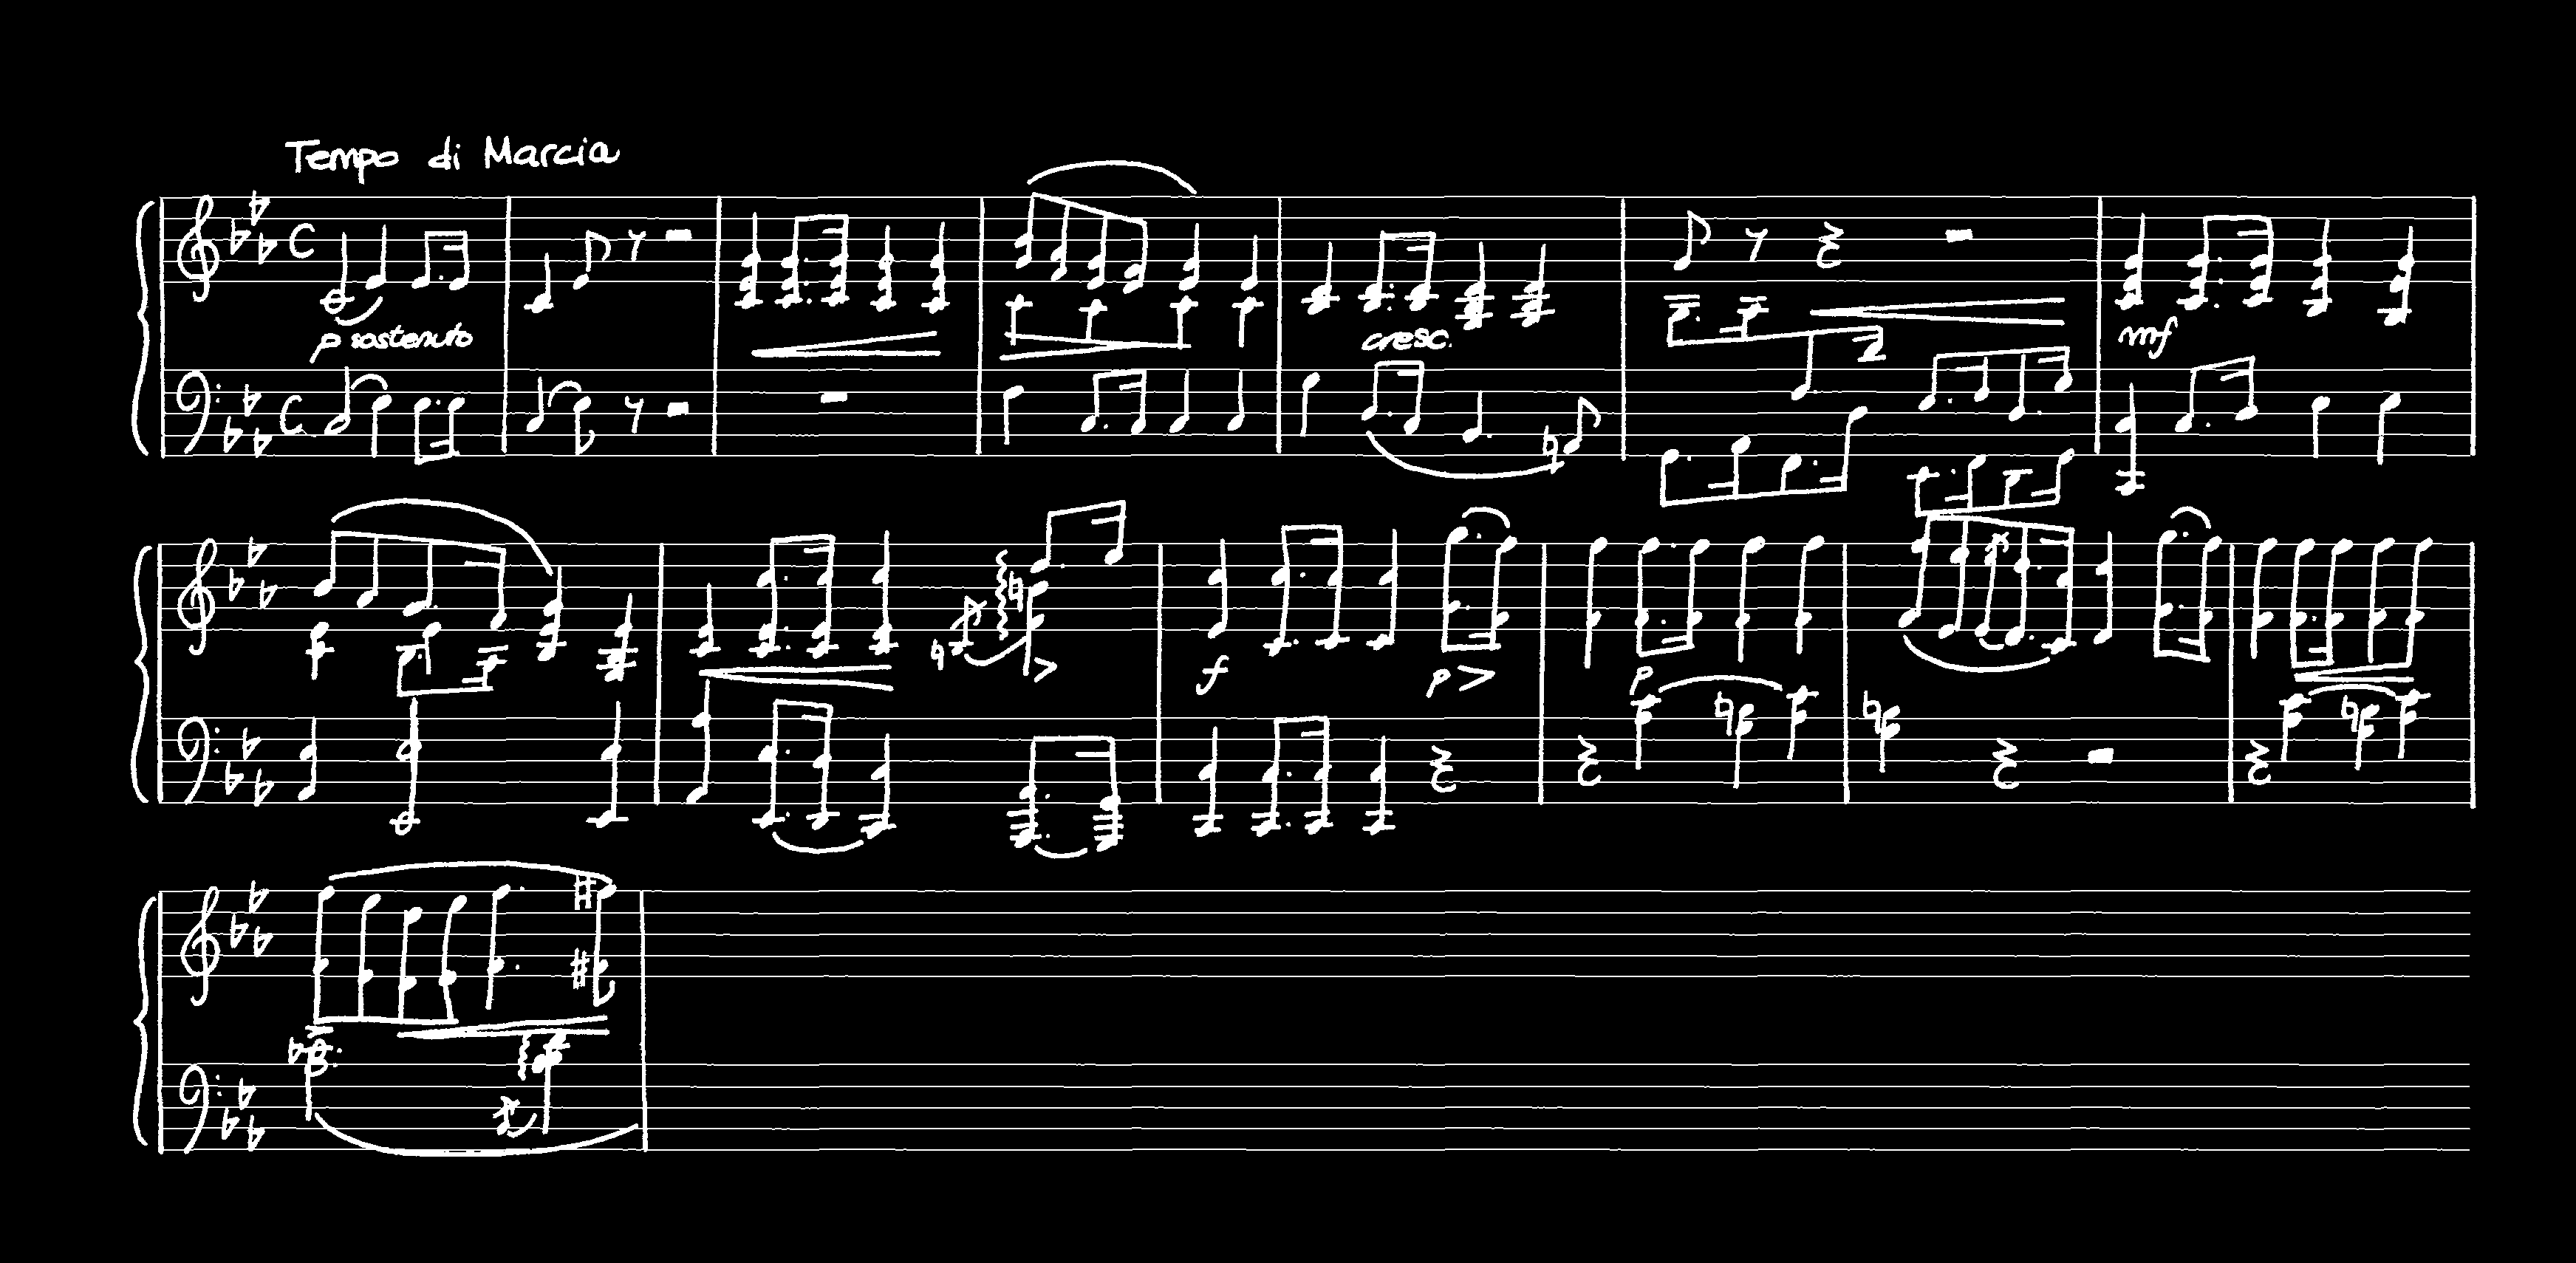

In [12]:
if __name__ == '__main__':
    # play_midi_file_from_disk()
    # exit()

    # sample_mung = "mung2midi/sample/CVC-MUSCIMA_W-01_N-10_D-ideal.xml"
    # sample_mung = "test/test_data/01_basic_binary_2.0.xml"
    sample_mung = "/Users/elona/Documents/GitHub/mung2midi/mung/test/test_data/CVC-MUSCIMA_W-01_N-10_D-ideal.pdo.xml"
    nodes = read_nodes_from_file(sample_mung)

    midi_file = convert_mung_to_midi(nodes)
    play_midi_file(midi_file)

Empty staffs: 


KeyboardInterrupt: 

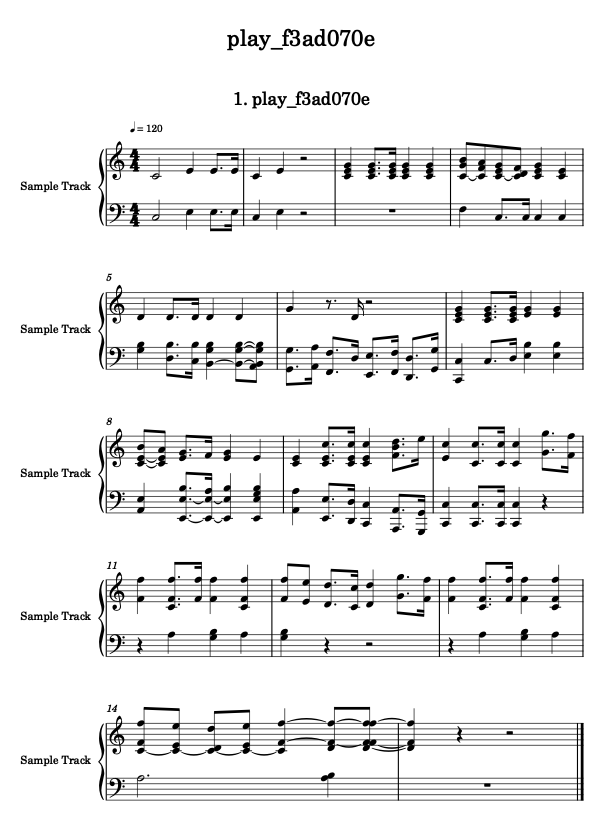